# BAGGING  | Machine Learning II

---
## Import modules

In [26]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
# import decision tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns
# others
from mltools import model_tools as MT

---
## Regression problem: calculate the solar power utilization at each hour 

#### 1.1 Load the two datasets and process them

In [27]:
# Load file with the dataset with irradiance data
df_irradiance = pd.read_csv('data/G04A_DATOS_IRRAD.csv', sep = ",")
df_irradiance.head()

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO,MES,DIA,DIASEM
0,2015-01-01,0.0,0.0,0.0,589813.00,1294089.50,468098.47,0.0,0.0,2015,1,1,3
1,2015-01-02,0.0,0.0,0.0,438244.75,989406.00,272884.66,0.0,0.0,2015,1,2,4
2,2015-01-03,0.0,0.0,0.0,543215.75,1162550.80,359685.12,0.0,0.0,2015,1,3,5
3,2015-01-04,0.0,0.0,0.0,504131.56,1229353.20,460497.50,0.0,0.0,2015,1,4,6
4,2015-01-05,0.0,0.0,0.0,502349.70,1012553.75,391783.16,0.0,0.0,2015,1,5,0


In [28]:
### Load file for the solar power utilization
df_util = pd.read_csv('data/G04A_DATOS_UTIL.csv', sep = ",")
df_util.head()

,FECHA,UTILH00,UTILH03,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21,ANNO,MES,DIA,DIASEM
0,2015-01-01,0.000023,0.000008,0.053105,0.590946,0.615057,0.091254,0.000008,0.000019,2015,1,1,3
1,2015-01-02,0.000012,0.000004,0.048031,0.397291,0.396714,0.048448,0.000000,0.000008,2015,1,2,4
2,2015-01-03,0.000008,0.000000,0.049542,0.557435,0.604719,0.091748,0.000004,0.000004,2015,1,3,5
3,2015-01-04,0.000008,0.000000,0.014918,0.375060,0.547907,0.090296,0.000016,0.000023,2015,1,4,6
4,2015-01-05,0.000008,0.000008,0.016370,0.167025,0.246309,0.051614,0.000004,0.000000,2015,1,5,0


In [29]:
df_aux = pd.merge(df_irradiance, df_util, on='FECHA')
df_aux

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO_x,...,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21,ANNO_y,MES_y,DIA_y,DIASEM_y
0,2015-01-01,0.0,0.0,0.0,589813.00,1294089.50,468098.470,0.0,0.0,2015,...,0.053105,0.590946,0.615057,0.091254,0.000008,0.000019,2015,1,1,3
1,2015-01-02,0.0,0.0,0.0,438244.75,989406.00,272884.660,0.0,0.0,2015,...,0.048031,0.397291,0.396714,0.048448,0.000000,0.000008,2015,1,2,4
2,2015-01-03,0.0,0.0,0.0,543215.75,1162550.80,359685.120,0.0,0.0,2015,...,0.049542,0.557435,0.604719,0.091748,0.000004,0.000004,2015,1,3,5
3,2015-01-04,0.0,0.0,0.0,504131.56,1229353.20,460497.500,0.0,0.0,2015,...,0.014918,0.375060,0.547907,0.090296,0.000016,0.000023,2015,1,4,6
4,2015-01-05,0.0,0.0,0.0,502349.70,1012553.75,391783.160,0.0,0.0,2015,...,0.016370,0.167025,0.246309,0.051614,0.000004,0.000000,2015,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2020-12-27,0.0,0.0,0.0,176437.95,596362.94,213554.200,0.0,0.0,2020,...,0.012102,0.068252,0.070849,0.012841,0.000003,0.000003,2020,12,27,6
2188,2020-12-28,0.0,0.0,0.0,573497.50,1097877.50,269206.560,0.0,0.0,2020,...,0.032334,0.334919,0.285503,0.046018,0.000003,0.000007,2020,12,28,0
2189,2020-12-29,0.0,0.0,0.0,425860.56,801252.40,237152.560,0.0,0.0,2020,...,0.023633,0.245105,0.282372,0.017419,0.000007,0.000007,2020,12,29,1
2190,2020-12-30,0.0,0.0,0.0,214860.45,321715.56,29951.986,0.0,0.0,2020,...,0.010654,0.134742,0.076885,0.005577,0.000010,0.000000,2020,12,30,2


In [30]:
# Lista de identificadores comunes
id_vars = ['FECHA', 'ANNO_x', 'MES_x', 'DIA_x', 'DIASEM_x']

# Melt para irradiancia
irrad_melt = pd.melt(df_aux, id_vars=id_vars, value_vars=['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18', 'IRRADH21'], var_name='HOUR', value_name='IRRAD_VALUE')

# Melt para utilidad
util_melt = pd.melt(df_aux, id_vars=id_vars, value_vars=['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 'UTILH12', 'UTILH15', 'UTILH18', 'UTILH21'], var_name='HOUR', value_name='UTIL_VALUE')

# Ajustar las columnas 'HOUR' para que coincidan y permitan un merge adecuado
irrad_melt['HOUR'] = irrad_melt['HOUR'].str.extract('(\d+)')
util_melt['HOUR'] = util_melt['HOUR'].str.extract('(\d+)')

# Realizar un merge de los DataFrames basado en las columnas comunes, incluida la 'HOUR'
df = pd.merge(irrad_melt, util_melt, on=id_vars + ['HOUR'])

df['FECHA'] = pd.to_datetime(df['FECHA'])

df['HOUR'] = df['HOUR'].astype(int)

df = df.drop(['DIASEM_x'], axis=1)
# Crea la nueva columna 'dia_mes' extrayendo el día del año
df['dia_mes'] = df['FECHA'].dt.dayofyear

df = df.drop(['FECHA'], axis=1)
df.to_csv('data/df.csv', index=False)
df

,ANNO_x,MES_x,DIA_x,HOUR,IRRAD_VALUE,UTIL_VALUE,dia_mes
0,2015,1,1,0,0.0,0.000023,1
1,2015,1,2,0,0.0,0.000012,2
2,2015,1,3,0,0.0,0.000008,3
3,2015,1,4,0,0.0,0.000008,4
4,2015,1,5,0,0.0,0.000008,5
...,...,...,...,...,...,...,...
17531,2020,12,27,21,0.0,0.000003,362
17532,2020,12,28,21,0.0,0.000007,363
17533,2020,12,29,21,0.0,0.000007,364
17534,2020,12,30,21,0.0,0.000000,365


#### 1.2 Exploratory analysis

In [31]:
# Basic exploratory analysis
print('\nInfo variables:')
print(df.describe())


Info variables:
             ANNO_x         MES_x         DIA_x         HOUR   IRRAD_VALUE  \
count  17536.000000  17536.000000  17536.000000  17536.00000  1.753600e+04   
mean    2017.500456      6.521898     15.732664     10.50000  5.132890e+05   
std        1.708230      3.449085      8.801621      6.87406  7.695626e+05   
min     2015.000000      1.000000      1.000000      0.00000  0.000000e+00   
25%     2016.000000      4.000000      8.000000      5.25000  0.000000e+00   
50%     2017.500000      7.000000     16.000000     10.50000  0.000000e+00   
75%     2019.000000     10.000000     23.000000     15.75000  8.401422e+05   
max     2020.000000     12.000000     31.000000     21.00000  2.927716e+06   

         UTIL_VALUE       dia_mes  
count  17536.000000  17536.000000  
mean       0.176620    183.166971  
std        0.244970    105.465788  
min       -0.000169      1.000000  
25%        0.000008     92.000000  
50%        0.019769    183.000000  
75%        0.325520    274.2

#### 1.3 Split the dataset in TR and TS

In [32]:
# Define input and output matrices
# input variables are: ANNO_x, MES_x, DIA_x, IRRAD_VALUE, HOUR, dia_mes
INPUTS = ['ANNO_x', 'MES_x', 'DIA_x', 'IRRAD_VALUE', 'HOUR', 'dia_mes']
OUTPUT = 'UTIL_VALUE'
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2024, #seed for replication
                                                    )   #Preserves distribution of y

### 1.4 Fit **single regression tree** (for comparison)

In [33]:
# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(5,40,1), # Minimum number of obs in a terminal node is 10
         'DT__min_samples_split':  np.arange(2,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                                     random_state=2024))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
# Voy a coger el TR y probar todas las combinaciones de parámetros. mid*msl*mss = 10*10*10 = 1000 modelos
# Por cada modelo de esos 1000, voy a calcular el accuracy con 10-fold CV. Entreno con 90% y testeo con 10%.
# El accuracy es la media de los 10 valores que obtengo.
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

## Inputs of the model
INPUTS_DT = INPUTS

tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=2024))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39]),
                         'DT__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [34]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2024,
 'splitter': 'best'}

##### 1.4.1 Plot the single classification tree

In [35]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
# plt.figure(figsize=(20, 10))
# plot_tree(tree_fit.best_estimator_['DT'],
#           feature_names= INPUTS_DT,
#           class_names= [str(s) for s in y_train.unique()],
#           fontsize=5, filled=True)
# plt.show()

In [36]:
# Easy reading of the tree
print(export_text(tree_fit.best_estimator_['DT'], feature_names= INPUTS_DT))

|--- IRRAD_VALUE <= 517591.53
|   |--- IRRAD_VALUE <= 3.04
|   |   |--- HOUR <= 12.00
|   |   |   |--- HOUR <= 4.50
|   |   |   |   |--- HOUR <= 1.50
|   |   |   |   |   |--- ANNO_x <= 2019.50
|   |   |   |   |   |   |--- ANNO_x <= 2016.50
|   |   |   |   |   |   |   |--- dia_mes <= 274.50
|   |   |   |   |   |   |   |   |--- DIA_x <= 7.50
|   |   |   |   |   |   |   |   |   |--- MES_x <= 4.50
|   |   |   |   |   |   |   |   |   |   |--- dia_mes <= 65.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- dia_mes >  65.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- MES_x >  4.50
|   |   |   |   |   |   |   |   |   |   |--- ANNO_x <= 2015.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- ANNO_x >  2015.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch o

##### 1.4.2 Compute errors of the single classification tree

In [37]:
# model predictions in training (TR) and test (TS) sets
clf = tree_fit.best_estimator_['DT']
y_train_pred_dt = clf.predict(X_train[INPUTS_DT])
y_test_pred_dt = clf.predict(X_test[INPUTS_DT])

# main metrics
mae_tr = mean_absolute_error(y_train, y_train_pred_dt)
mae_ts = mean_absolute_error(y_test, y_test_pred_dt)

mse_tr = mean_squared_error(y_train, y_train_pred_dt)
mse_ts = mean_squared_error(y_test, y_test_pred_dt)

r2_tr = r2_score(y_train, y_train_pred_dt)
r2_ts = r2_score(y_test, y_test_pred_dt)

rmse_tr = np.sqrt(mse_tr)
rmse_ts = np.sqrt(mse_ts)

# Construct DataFrame for metrics
df_metrics = pd.DataFrame([[mae_tr, mae_ts], [mse_tr, mse_ts], [r2_tr, r2_ts], [rmse_tr, rmse_ts]], 
                          index=['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Root Mean Squared Error'], 
                          columns=['TR', 'TS'])
print(df_metrics)

                               TR        TS
Mean Absolute Error      0.021849  0.035153
Mean Squared Error       0.002012  0.005119
R-squared                0.966587  0.913400
Root Mean Squared Error  0.044860  0.071549


##### 1.4.3 Importances of the inputs in the single tree

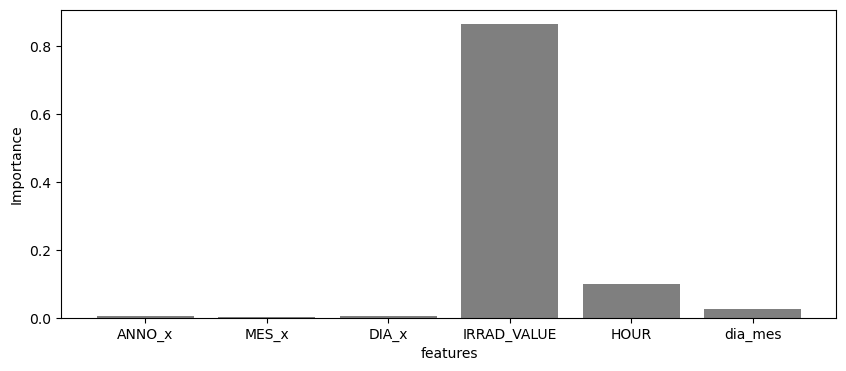

In [38]:
## Plot the variable importance of each feature
plt.figure(figsize=(10, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

### 1.5 Fit Bagged tree

##### 1.5.1 First straightforward version (without optim hyperparameters)

In [39]:
number_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                                            min_impurity_decrease=0.0, # Minimum entropy to decrease in each split
                                                            min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            random_state=2024))]) # For replication


# Lo que hace la función es entrenar 50 árboles con el mismo dataset, pero con diferentes subconjuntos de variables y observaciones.
bt_fit_straightforward = BaggingRegressor(base_estimator=base_estimator, # Decision Tree
                                   n_estimators=number_estimators, # Number of trees
                                   random_state=2024, # Seed for replication
                                   n_jobs=-1) # Parallelize
                     
# fit the bagged trees
INPUTS_BT = INPUTS                 
bt_fit_straightforward.fit(X_train[INPUTS_BT], y_train)

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=Pipeline(steps=[('DT',
                                                 DecisionTreeRegressor(min_samples_leaf=5,
                                                                       random_state=2024))]),
                 n_estimators=50, n_jobs=-1, random_state=2024)

In [40]:
clf = bt_fit_straightforward
# model predictions in training (TR) and test (TS) sets
y_train_pred_bt = clf.predict(X_train[INPUTS_BT])
y_test_pred_bt = clf.predict(X_test[INPUTS_BT])

# Calculate Mean Absolute Error (MAE)
mae_tr = metrics.mean_absolute_error(y_train, y_train_pred_bt)
mae_ts = metrics.mean_absolute_error(y_test, y_test_pred_bt)

# Calculate Mean Squared Error (MSE)
mse_tr = metrics.mean_squared_error(y_train, y_train_pred_bt)
mse_ts = metrics.mean_squared_error(y_test, y_test_pred_bt)

# Calculate R-squared (R^2) score
r2_tr = metrics.r2_score(y_train, y_train_pred_bt)
r2_ts = metrics.r2_score(y_test, y_test_pred_bt)

rmse_tr = np.sqrt(mse_tr)
rmse_ts = np.sqrt(mse_ts)

# Construct DataFrame for metrics
df_metrics_bt = pd.DataFrame([[mae_tr, mae_ts], [mse_tr, mse_ts], [r2_tr, r2_ts], [rmse_tr, rmse_ts]], 
                          index=['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Root Mean Squared Error'], 
                          columns=['TR', 'TS'])
print(df_metrics_bt)

                               TR        TS
Mean Absolute Error      0.020365  0.030732
Mean Squared Error       0.001702  0.003838
R-squared                0.971746  0.935073
Root Mean Squared Error  0.041252  0.061952


##### 1.5.2 Feature importance evaluation in bagging using "Permutation Importance"

The permutation importance of a feature is calculated as follows:
- First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. 
- Next, a feature column from the validation set is permuted and the metric is evaluated again. 
- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.


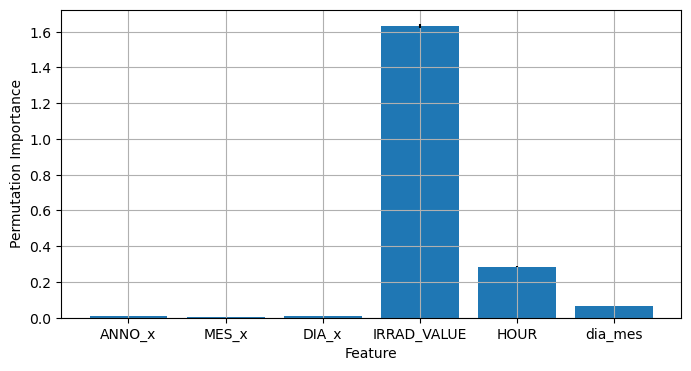

In [41]:
importances_bag_class_estim = permutation_importance(bt_fit_straightforward, 
                                    X_train[INPUTS_BT], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_BT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### 1.5.4 Variability in the ensemble

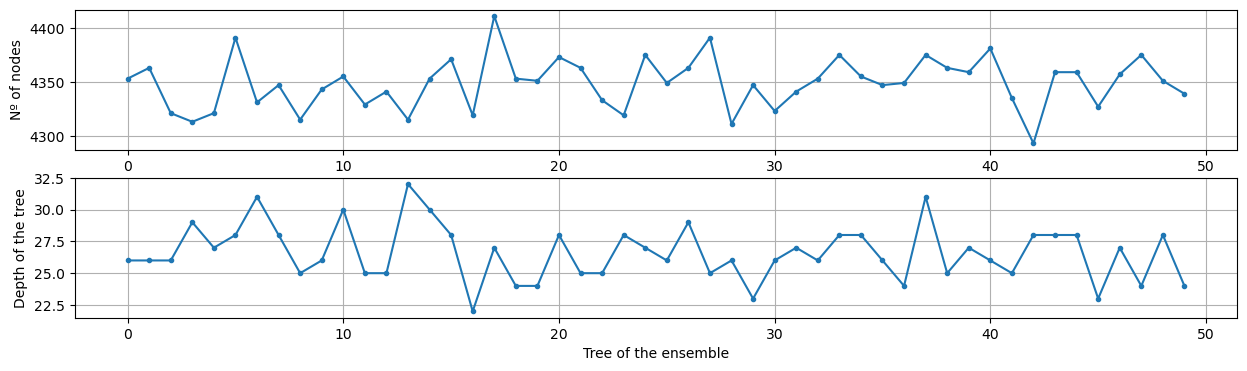

In [42]:
# number of nodes in each tree of the ensemble
node_count_trees = [t['DT'].tree_.node_count for t in bt_fit_straightforward.estimators_]

# number of nodes in each tree of the ensemble
depth_trees = [t['DT'].tree_.max_depth for t in bt_fit_straightforward.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees, '.-')
plt.ylabel('Nº of nodes')                       
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

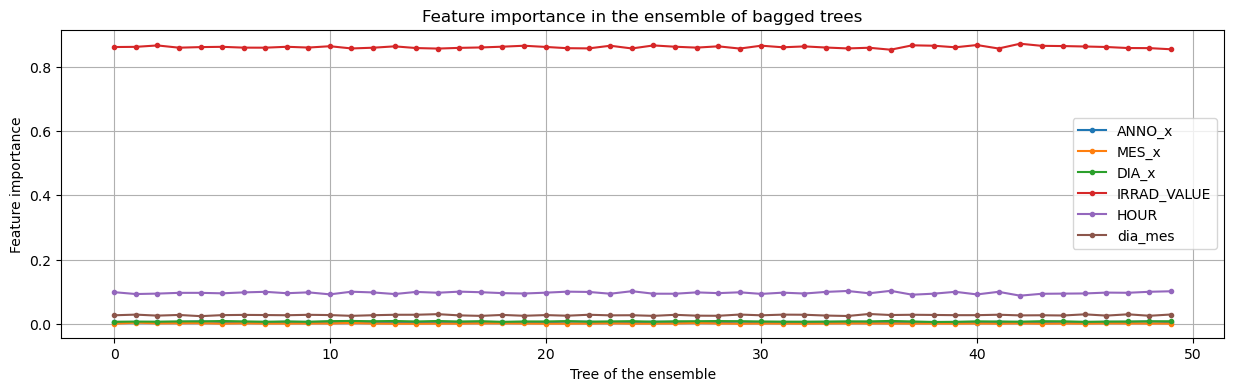

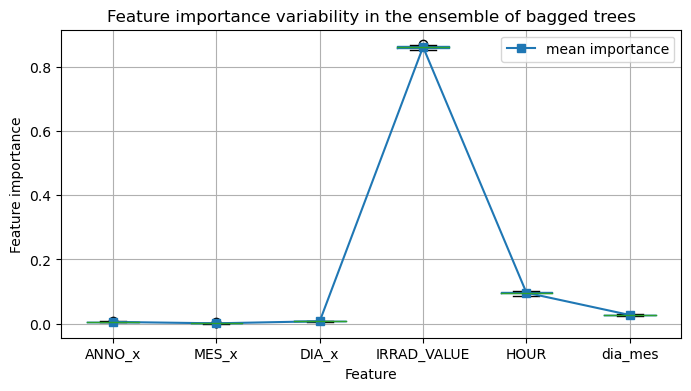

In [43]:
# feature importances of each tree in the ensemble
feature_importances_trees = [t['DT'].feature_importances_ for t in bt_fit_straightforward.estimators_]

fig = plt.figure(1, figsize=(15, 4))
plt.plot(feature_importances_trees, '.-', label = INPUTS_BT)
plt.ylabel('Feature importance') 
plt.xlabel('Tree of the ensemble')                                 
plt.title('Feature importance in the ensemble of bagged trees')
plt.grid()
plt.legend()
plt.show()

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(8, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

### Plot the residuals of the ensemble

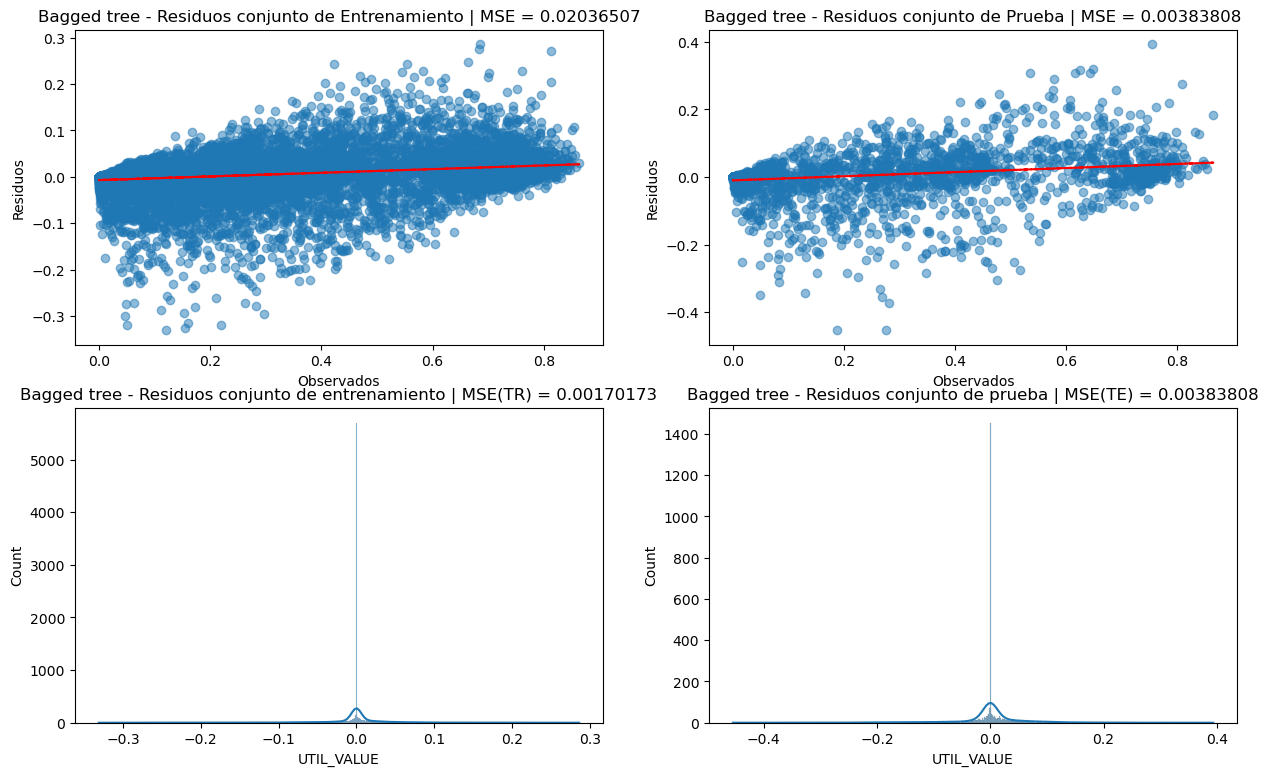

In [44]:
# Graficar los residuos (dispersión e histograma) del modelo XGBoost
plt.figure(figsize=(15, 9))

# Calcular residuos
residuals_train_bt = y_train - y_train_pred_bt
residuals_test_bt = y_test - y_test_pred_bt

# Gráficas de dispersión con línea de tendencia
for i, (y, residuals, title) in enumerate([
    (y_train, residuals_train_bt, 'Entrenamiento'),
    (y_test, residuals_test_bt, 'Prueba')
], start=1):
    plt.subplot(2, 2, i)
    plt.scatter(y, residuals, alpha=0.5)
    # Calcular línea de tendencia
    z = np.polyfit(y, residuals, 1)
    p = np.poly1d(z)
    plt.plot(y, p(y), "r--")  # Dibuja la línea de tendencia
    plt.title(f'Bagged tree - Residuos conjunto de {title} | MSE = {mae_tr:.8f}' if i == 1 else f'Bagged tree - Residuos conjunto de {title} | MSE = {mse_ts:.8f}')
    plt.xlabel('Observados')
    plt.ylabel('Residuos')

# Histogramas
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_bt, kde=True)
plt.title(f'Bagged tree - Residuos conjunto de entrenamiento | MSE(TR) = {mse_tr:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_bt, kde=True)
plt.title(f'Bagged tree - Residuos conjunto de prueba | MSE(TE) = {mse_ts:.8f}')

# Mostrar gráfica
plt.show()

### 1.6 Fit optimal regression bagged tree using Grid Search

In [20]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the parameter grid for grid search
param = {'BT__n_estimators': range(20, 160, 5)} # Number of trees to aggregate

# Create the pipeline with BaggingRegressor as the estimator
pipe = Pipeline(steps=[('BT', BaggingRegressor(random_state=150))])

# Use Grid Search Cross Validation to find the best parameter for the model in the defined grid
nFolds = 10
bt_fit_optimal = GridSearchCV(estimator=pipe, # Structure of the model to use
                      param_grid=param, # Defined grid to search in
                      n_jobs=-1, # Number of cores to use (parallelize)
                      scoring='neg_mean_squared_error', # Regression metric
                      cv=nFolds) # Number of Folds 

# Fit the bagged trees
bt_fit_optimal.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 160, 5)},
             scoring='neg_mean_squared_error')

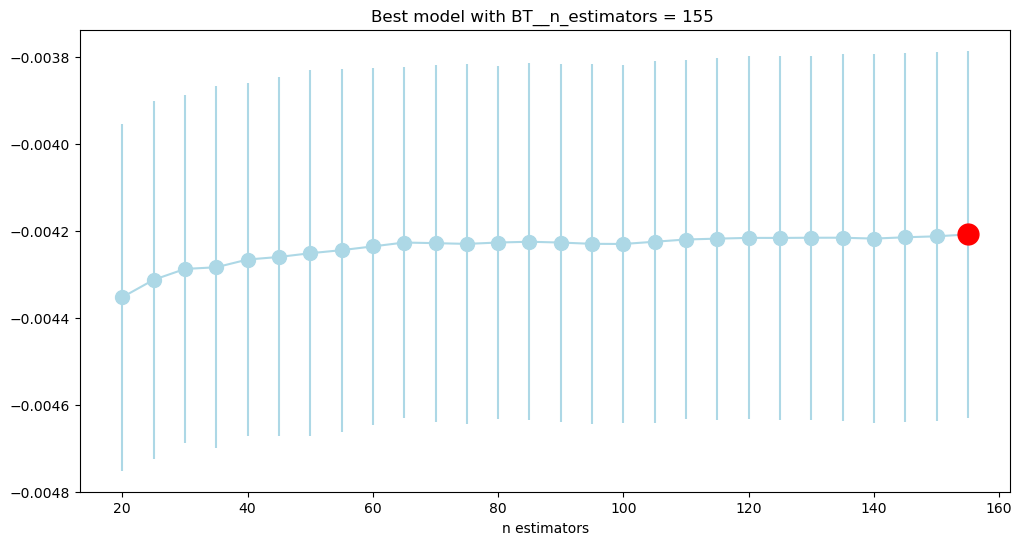

In [21]:
MT.plotModelGridError(bt_fit_optimal)

### Evaluate the model performance

In [22]:
# model predictions in training (TR) and test (TS) sets
clf = bt_fit_optimal
y_train_pred_gs_bt = clf.predict(X_train[INPUTS_DT])
y_test_pred_gs_bt = clf.predict(X_test[INPUTS_DT])

# Calculate Mean Absolute Error (MAE)
mae_tr = metrics.mean_absolute_error(y_train, y_train_pred_gs_bt)
mae_ts = metrics.mean_absolute_error(y_test, y_test_pred_gs_bt)

# Calculate Mean Squared Error (MSE)
mse_tr = metrics.mean_squared_error(y_train, y_train_pred_gs_bt)
mse_ts = metrics.mean_squared_error(y_test, y_test_pred_gs_bt)

# Calculate R-squared (R^2) score
r2_tr = metrics.r2_score(y_train, y_train_pred_gs_bt)
r2_ts = metrics.r2_score(y_test, y_test_pred_gs_bt)

rmse_tr = np.sqrt(mse_tr)
rmse_ts = np.sqrt(mse_ts)

# Construct DataFrame for metrics
df_metrics = pd.DataFrame([[mae_tr, mae_ts], [mse_tr, mse_ts], [r2_tr, r2_ts], [rmse_tr, rmse_ts]], 
                          index=['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Root Mean Squared Error'], 
                          columns=['TR', 'TS'])
print(df_metrics)

                               TR        TS
Mean Absolute Error      0.011923  0.030950
Mean Squared Error       0.000580  0.003929
R-squared                0.990372  0.933527
Root Mean Squared Error  0.024081  0.062685


### Plot the variable importance of each feature

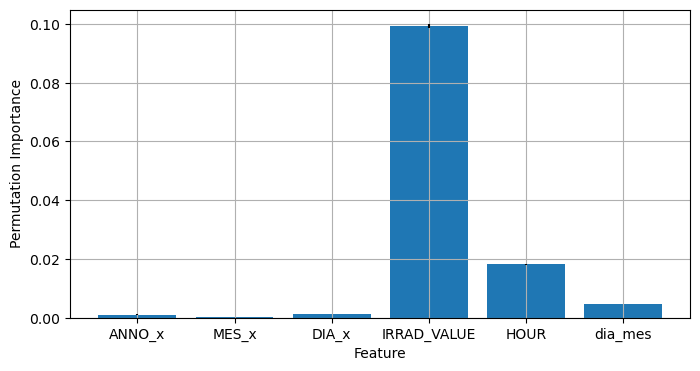

In [23]:
importances_bag_class_estim = permutation_importance(bt_fit_optimal, 
                                    X_train[INPUTS_BT], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_BT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

### Plot the residuals of the model

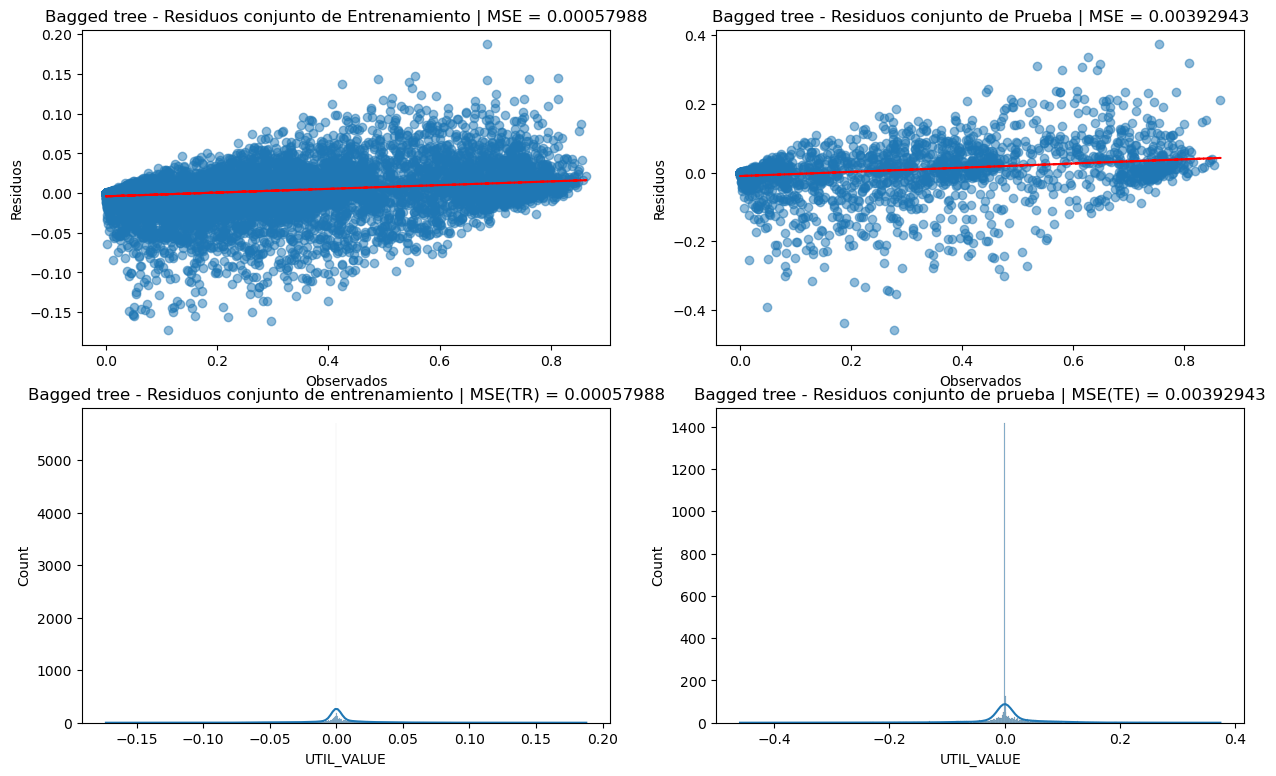

In [24]:
# Graficar los residuos (dispersión e histograma) del modelo XGBoost
plt.figure(figsize=(15, 9))

# Calcular residuos
residuals_train_bt = y_train - y_train_pred_gs_bt
residuals_test_bt = y_test - y_test_pred_gs_bt

# Gráficas de dispersión con línea de tendencia
for i, (y, residuals, title) in enumerate([
    (y_train, residuals_train_bt, 'Entrenamiento'),
    (y_test, residuals_test_bt, 'Prueba')
], start=1):
    plt.subplot(2, 2, i)
    plt.scatter(y, residuals, alpha=0.5)
    # Calcular línea de tendencia
    z = np.polyfit(y, residuals, 1)
    p = np.poly1d(z)
    plt.plot(y, p(y), "r--")  # Dibuja la línea de tendencia
    plt.title(f'Bagged tree - Residuos conjunto de {title} | MSE = {mse_tr:.8f}' if i == 1 else f'Bagged tree - Residuos conjunto de {title} | MSE = {mse_ts:.8f}')
    plt.xlabel('Observados')
    plt.ylabel('Residuos')

# Histogramas
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_bt, kde=True)
plt.title(f'Bagged tree - Residuos conjunto de entrenamiento | MSE(TR) = {mse_tr:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_bt, kde=True)
plt.title(f'Bagged tree - Residuos conjunto de prueba | MSE(TE) = {mse_ts:.8f}')

# Mostrar gráfica
plt.show()
